In [260]:
%matplotlib inline

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import pandas as pd
from nltk.metrics.distance import edit_distance
from tqdm import tqdm_notebook
import seaborn as sns
import copy
import numpy as np
from nltk.corpus import stopwords
import nltk
import string

In [2]:
root = '/local/aida/'

In [3]:
dataFolder = root+'Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/'

In [4]:
files = glob.glob(dataFolder+'*.xml')

In [5]:
#Figure out which file goes with which topic
t101_list = [i.split('/')[-1][:-4] for i in glob.glob(root+'LDCAnnotations/T101/*.ttl') \
             if i.split('/')[-1][0]=='H' or i.split('/')[-1][0]=='I']
t102_list = [i.split('/')[-1][:-4] for i in glob.glob(root+'LDCAnnotations/T102/*.ttl') \
             if i.split('/')[-1][0]=='H' or i.split('/')[-1][0]=='I']
t103_list = [i.split('/')[-1][:-4] for i in glob.glob(root+'LDCAnnotations/T103/*.ttl') \
             if i.split('/')[-1][0]=='H' or i.split('/')[-1][0]=='I']

In [6]:
file_names = [i.split('/')[-1][11:-12] for i in files]
t101_files = []
t102_files = []
t103_files = []
for name,file in zip(file_names,files):
    if name in t101_list:
        t101_files.append(file)
    elif name in t102_list:
        t102_files.append(file)
    elif name in t103_list:
        t103_files.append(file)
    else:
        print('Error: file not in any list',file)
        
    if (name in t101_list and name in t102_list) or (name in t101_list and name in t103_list) or \
        (name in t102_list and name in t103_list):
            print('Duplicate',file)

Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7WJ.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7YH.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7R3.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7RC.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7ME.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7MD.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q812.rsd.txt.xml
Error: file not in any list /local/aida/Seedling_Corpus_V1/extracted_data/ltf-data-corenlp/translated_HC000Q7WM.rsd.txt.xml
Error: f

In [7]:
print(len(t101_files),len(t102_files),len(t103_files))

53 37 51


In [13]:
def getEntities(files):
    entities = {}
    for file in tqdm_notebook(files):
        tree = ET.parse(file)
        root = tree.getroot()

        all_document = root.findall('document')
        if len(all_document) != 1:
            print('ERROR: More or less than one document found')
        document = all_document[0]
        #Children of document: docId, sentences, coreference

        all_sentences = document.findall('sentences')
        if len(all_sentences) != 1:
            print('ERROR: More or less than one sentences found')
        sentences = all_sentences[0]

        for sentence in sentences:
            #Children of sentence: tokens, parse, dependencies (multiple)

            all_tokens = sentence.findall('tokens')
            if len(all_tokens) != 1:
                print('ERROR: More or less than one tokens found in sentence')
            tokens = all_tokens[0]

            tokens = tokens.findall('token')
            current_entity = ['','']
            for token in tokens:
                #Children of token: word, lemma, CharacterOffsetBegin, CharacterOffsetEnd, POS, NER, Speaker, Sentiment
                all_ner = token.findall('NER')
                if len(all_ner) != 1:
                    print('ERROR: More or less than one NER for this token')
                ner = all_ner[0]

                all_word = token.findall('word')
                if len(all_word) != 1:
                    print('ERROR: More or less than one word for this token')
                word = all_word[0]

                if ner.text != 'O' and ner.text != 'URL':
                    if current_entity[1] == '': #new entity
                        current_entity[0] = word.text
                        current_entity[1] = ner.text
                    elif current_entity[1] == ner.text: #Continuation of same entity
                        current_entity[0] += ' '+word.text
                    else: #New entity
                        if current_entity[1] in entities:
                            entities[current_entity[1]].append(current_entity[0])
                        else:
                            entities[current_entity[1]] = [current_entity[0]]
                        current_entity[0] = word.text
                        current_entity[1] = ner.text  
                elif current_entity[1] != '':
                    if current_entity[1] in entities:
                        entities[current_entity[1]].append(current_entity[0])
                    else:
                        entities[current_entity[1]] = [current_entity[0]]
                    current_entity[0] = ''
                    current_entity[1] = ''
                    
    #Remove duplicate entities
    return_entities = []
    for key,values in entities.items():
        for value in values:
            return_entities.append((value,key))
    return_entities = list(set(return_entities))
    return return_entities

In [14]:
t101_entities_corenlp = getEntities(t101_files)
t102_entities_corenlp = getEntities(t102_files)
t103_entities_corenlp = getEntities(t103_files)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [15]:
def extractEntities(file):
    entities101_file = pd.read_csv(file,sep='\t')
    
    entities101 = []
    for it,row in entities101_file.iterrows():
        if row.text_string==row.text_string:
            entities101.append((row.text_string,row.type))
            
    entities101_set = list(set(entities101))
    
    return entities101_set

In [16]:
base = '/local/aida/Scenario_1_Seedling_Annotation_V3.0/data/'

t101_entities_darpa = extractEntities(base+'T101_translated/translated_T101_ent_mentions.tab')
t102_entities_darpa = extractEntities(base+'T102_translated/translated_T102_ent_mentions.tab')
t103_entities_darpa = extractEntities(base+'T103_translated/translated_T103_ent_mentions.tab')

In [197]:
base = '/local/aida/Scenario_1_Seedling_Annotation_V3.0/data/'

t101_events_darpa = extractEntities(base+'T101_translated/translated_T101_evt_mentions.tab')
t102_events_darpa = extractEntities(base+'T102_translated/translated_T102_evt_mentions.tab')
t103_events_darpa = extractEntities(base+'T103_translated/translated_T103_evt_mentions.tab')

In [21]:
corenlp_categories = list(set([i[1] for i in t101_entities_corenlp+t102_entities_corenlp+t103_entities_corenlp]))
darpa_categories = list(set([i[1] for i in t101_entities_darpa+t102_entities_darpa+t103_entities_darpa]))

In [22]:
darpa_categories

['crm',
 'gpe',
 'per',
 'veh',
 'wea',
 'val',
 'sid',
 'tme',
 'org',
 'ttl',
 'fac',
 'loc',
 'com']

In [198]:
darpa_event_categories = list(set([i[1] for i in t101_events_darpa+t102_events_darpa+t103_events_darpa]))

In [199]:
darpa_event_categories

['manufacture',
 'contact',
 'transaction',
 'justice',
 'personnel',
 'movement',
 'conflict',
 'life']

In [274]:
t101_entities_corenlp_lower = [(i[0].lower(),i[1]) for i in t101_entities_corenlp]
t102_entities_corenlp_lower = [(i[0].lower(),i[1]) for i in t102_entities_corenlp]
t103_entities_corenlp_lower = [(i[0].lower(),i[1]) for i in t103_entities_corenlp]
t101_entities_darpa_lower = [(i[0].lower(),i[1]) for i in t101_entities_darpa]
t102_entities_darpa_lower = [(i[0].lower(),i[1]) for i in t102_entities_darpa]
t103_entities_darpa_lower = [(i[0].lower(),i[1]) for i in t103_entities_darpa]
t101_events_darpa_lower = [(i[0].lower(),i[1]) for i in t101_events_darpa]
t102_events_darpa_lower = [(i[0].lower(),i[1]) for i in t102_events_darpa]
t103_events_darpa_lower = [(i[0].lower(),i[1]) for i in t103_events_darpa]

In [279]:
def recall_precision(corenlp_category,darpa_category,t101_entities_corenlp,t101_entities_darpa):
    t101_entities_corenlp_first = set([i[0] for i in t101_entities_corenlp if i[1]==corenlp_category])
    #print(t101_entities_corenlp_first)
    t101_entities_darpa_first = set([i[0] for i in t101_entities_darpa if i[1]==darpa_category])
    #print(t101_entities_darpa_first)
    if len(t101_entities_darpa_first) == 0:
        t101_recall = 0 #not technically correct
    else:
        t101_recall = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_darpa_first)
    if len(t101_entities_corenlp_first) == 0:
        t101_precision = 0 #not technically correct
    else:
        t101_precision = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_corenlp_first)
    return(t101_recall,t101_precision)

In [280]:
def recall_precision_overall_corenlp(darpa_category,t101_entities_corenlp,t101_entities_darpa):
    t101_entities_corenlp_first = set([i[0] for i in t101_entities_corenlp])
    #print(t101_entities_corenlp_first)
    t101_entities_darpa_first = set([i[0] for i in t101_entities_darpa if i[1]==darpa_category])
    #print(t101_entities_darpa_first)
    if len(t101_entities_darpa_first) == 0:
        t101_recall = 0 #not technically correct
    else:
        t101_recall = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_darpa_first)
    if len(t101_entities_corenlp_first) == 0:
        t101_precision = 0 #not technically correct
    else:
        t101_precision = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_corenlp_first)
    return(t101_recall,t101_precision)

In [281]:
all_recall = []
all_precision = []
for corenlp_category in corenlp_categories:
    recall = []
    precision = []
    for darpa_category in darpa_categories:
        #Average recall - how many of the relevant items are selected?
        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_lower,t101_entities_darpa_lower)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_lower,t102_entities_darpa_lower)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_lower,t103_entities_darpa_lower)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        recall.append(avg_recall)
        precision.append(avg_precision)
    all_recall.append(recall)
    all_precision.append(precision)

In [282]:
mask = []
for i in range(len(all_recall)):
    _mask = []
    for j in range(len(all_recall[0])):
        if all_recall[i][j] == 0:
            _mask.append(True)
        else:
            _mask.append(False)
    mask.append(_mask)
plt.rcParams["figure.figsize"] = (12,8)
sns.heatmap(all_recall,xticklabels=darpa_categories,yticklabels=corenlp_categories,mask=np.matrix(mask),\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [283]:
mask = []
for i in range(len(all_precision)):
    _mask = []
    for j in range(len(all_precision[0])):
        if all_precision[i][j] == 0:
            _mask.append(True)
        else:
            _mask.append(False)
    mask.append(_mask)
plt.rcParams["figure.figsize"] = (12,8)
sns.heatmap(all_precision,xticklabels=darpa_categories,yticklabels=corenlp_categories,mask=np.matrix(mask),\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [284]:
def overall_recall_precision(t101_entities_corenlp,t101_entities_darpa):
    t101_entities_corenlp_first = set([i[0] for i in t101_entities_corenlp])
    #print(t101_entities_corenlp_first)
    t101_entities_darpa_first = set([i[0] for i in t101_entities_darpa])
    #print(t101_entities_darpa_first)
    if len(t101_entities_darpa_first) == 0:
        t101_recall = 0 #Not technically correct
    else:
        t101_recall = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_darpa_first)
    if len(t101_entities_corenlp_first) == 0:
        t101_precision = 0 #Not technically correct
    else:
        t101_precision = len([i for i in t101_entities_corenlp_first if i in t101_entities_darpa_first]) / \
                        len(t101_entities_corenlp_first)
    return(t101_recall,t101_precision)

In [285]:
#Overall precision and recall
print(overall_recall_precision(t101_entities_corenlp_lower,t101_entities_darpa_lower))
print(overall_recall_precision(t102_entities_corenlp_lower,t102_entities_darpa_lower))
print(overall_recall_precision(t103_entities_corenlp_lower,t103_entities_darpa_lower))

(0.19476744186046513, 0.03852788959171938)
(0.2469879518072289, 0.04806565064478312)
(0.2616487455197133, 0.04828042328042328)


In [286]:
#What if we remove unnecessary corenlp categories?
corenlp_keep = ['LOCATION','MISC','COUNTRY','TITLE','NATIONALITY','CAUSE_OF_DEATH','STATE_OR_PROVINCE','NUMBER',\
               'CRIMINAL_CHARGE','DATE','PERSON','ORGANIZATION','CITY']

In [287]:
print(overall_recall_precision([i for i in t101_entities_corenlp_lower if i[1] in corenlp_keep],t101_entities_darpa_lower))
print(overall_recall_precision([i for i in t102_entities_corenlp_lower if i[1] in corenlp_keep],t102_entities_darpa_lower))
print(overall_recall_precision([i for i in t103_entities_corenlp_lower if i[1] in corenlp_keep],t103_entities_darpa_lower))

(0.19476744186046513, 0.04205900816070308)
(0.2469879518072289, 0.05380577427821522)
(0.2616487455197133, 0.05576776165011459)


In [288]:
all_recall = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))
all_precision = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))

for corenlp_category_index in range(len(corenlp_keep)):
    for darpa_category_index in range(len(darpa_categories)):
        corenlp_category = corenlp_keep[corenlp_category_index]
        darpa_category = darpa_categories[darpa_category_index]

        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_lower,t101_entities_darpa_lower)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_lower,t102_entities_darpa_lower)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_lower,t103_entities_darpa_lower)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        
        all_recall[corenlp_category_index,darpa_category_index] = avg_recall
        all_precision[corenlp_category_index,darpa_category_index] = avg_precision
        
for darpa_category_index in range(len(darpa_categories)):
    darpa_category = darpa_categories[darpa_category_index]
    
    (t101_recall,t101_precision) = recall_precision_overall_corenlp(darpa_category,t101_entities_corenlp_lower,t101_entities_darpa_lower)
    (t102_recall,t102_precision) = recall_precision_overall_corenlp(darpa_category,t102_entities_corenlp_lower,t102_entities_darpa_lower)
    (t103_recall,t103_precision) = recall_precision_overall_corenlp(darpa_category,t103_entities_corenlp_lower,t103_entities_darpa_lower)    
    avg_recall = (t101_recall+t102_recall+t103_recall)/3
    avg_precision = (t101_precision+t102_precision+t103_precision)/3
    
    all_recall[len(corenlp_keep),darpa_category_index] = avg_recall
    all_precision[len(corenlp_keep),darpa_category_index] = avg_precision

In [289]:
darpa_full_categories = ['Crime','Geo-Political Entity','Person','Vehicle','Weapon','Numerical Value','Side',\
                        'Time','Organization','Title','Facility','Location','Commodity']

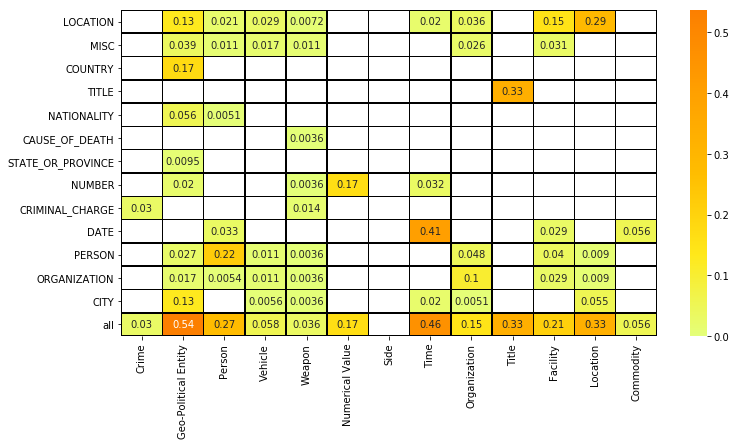

In [290]:
mask = np.zeros(all_recall.shape)
for i in range(len(all_recall)):
    for j in range(len(all_recall[0])):
        if all_recall[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(all_recall,xticklabels=darpa_full_categories,yticklabels=corenlp_keep+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

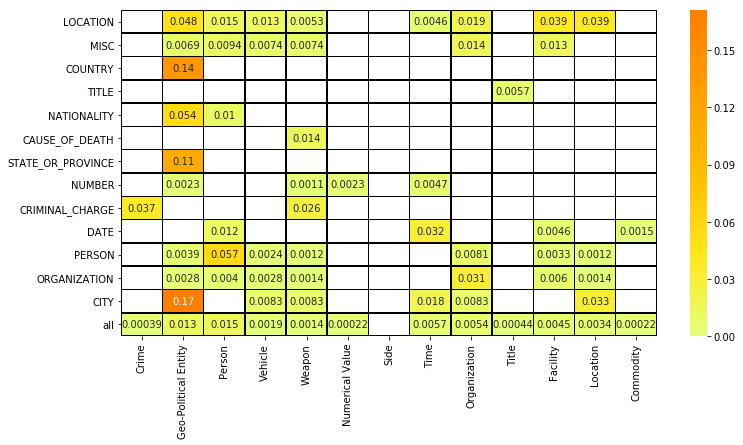

In [291]:
mask = np.zeros(all_precision.shape)
for i in range(len(all_precision)):
    for j in range(len(all_precision[0])):
        if all_precision[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(all_precision,xticklabels=darpa_full_categories,yticklabels=corenlp_keep+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [292]:
#What entities are we missing?
missing_t101 = [i for i in t101_entities_darpa_lower if i[0] not in [j[0] for j in t101_entities_corenlp_lower]]
missing_t102 = [i for i in t102_entities_darpa_lower if i[0] not in [j[0] for j in t102_entities_corenlp_lower]]
missing_t103 = [i for i in t103_entities_darpa_lower if i[0] not in [j[0] for j in t103_entities_corenlp_lower]]

In [293]:
[i[0] for i in missing_t101+missing_t102+missing_t103 if i[1]=='gpe']

['ukraine forces',
 'militias',
 'russia.',
 '17-jul',
 'the ukrainian military',
 'combat aircraft of the air force of ukraine',
 'a rebel-controlled village',
 'of russia',
 'donetsk region',
 'rf',
 'the netherlands',
 'independent country',
 'spetsnaz',
 'the donetsk region',
 'of ukraine',
 'snowy',
 'peoples republic of donetsk',
 'home',
 'yacht',
 'of ukraine',
 'of russia',
 'kyiv',
 'kyiv',
 '___',
 'of donetsk',
 'of the crimea',
 '________',
 '_______',
 'rostov-na-donu',
 'of kyiv',
 'aeska',
 '_______________',
 'rf',
 '______',
 '____',
 'of ukraine',
 '__',
 'of russia',
 '_______',
 '_____',
 '______',
 'in kiev',
 '____']

In [294]:
#What if we remove stopwords and punctuation?
stop = set(stopwords.words('english'))
t101_entities_darpa_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t101_entities_darpa_lower]
t102_entities_darpa_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t102_entities_darpa_lower]
t103_entities_darpa_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t103_entities_darpa_lower]
t101_entities_corenlp_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t101_entities_corenlp_lower]
t102_entities_corenlp_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t102_entities_corenlp_lower]
t103_entities_corenlp_cleaned = [(' '.join([word for word in nltk.word_tokenize(i[0]) if word not in stop and word not in string.punctuation]),i[1]) \
                               for i in t103_entities_corenlp_lower]

In [295]:
all_recall = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))
all_precision = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))

for corenlp_category_index in range(len(corenlp_keep)):
    for darpa_category_index in range(len(darpa_categories)):
        corenlp_category = corenlp_keep[corenlp_category_index]
        darpa_category = darpa_categories[darpa_category_index]

        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_cleaned,t101_entities_darpa_cleaned)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_cleaned,t102_entities_darpa_cleaned)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_cleaned,t103_entities_darpa_cleaned)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        
        all_recall[corenlp_category_index,darpa_category_index] = avg_recall
        all_precision[corenlp_category_index,darpa_category_index] = avg_precision
        
for darpa_category_index in range(len(darpa_categories)):
    darpa_category = darpa_categories[darpa_category_index]
    
    (t101_recall,t101_precision) = recall_precision_overall_corenlp(darpa_category,t101_entities_corenlp_cleaned,t101_entities_darpa_cleaned)
    (t102_recall,t102_precision) = recall_precision_overall_corenlp(darpa_category,t102_entities_corenlp_cleaned,t102_entities_darpa_cleaned)
    (t103_recall,t103_precision) = recall_precision_overall_corenlp(darpa_category,t103_entities_corenlp_cleaned,t103_entities_darpa_cleaned)    
    avg_recall = (t101_recall+t102_recall+t103_recall)/3
    avg_precision = (t101_precision+t102_precision+t103_precision)/3
    
    all_recall[len(corenlp_keep),darpa_category_index] = avg_recall
    all_precision[len(corenlp_keep),darpa_category_index] = avg_precision

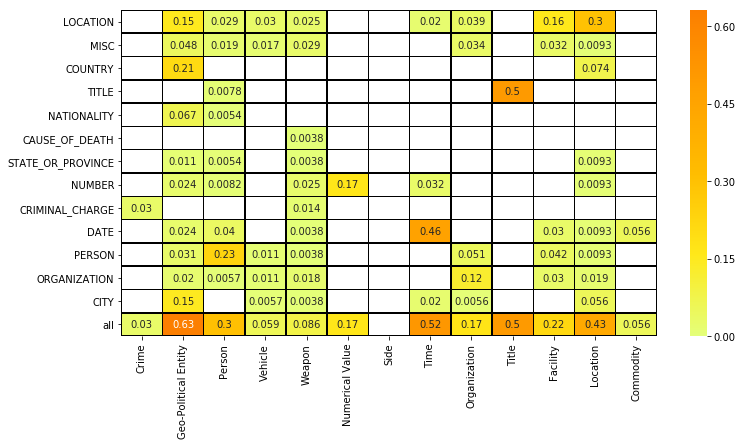

In [297]:
mask = np.zeros(all_recall.shape)
for i in range(len(all_recall)):
    for j in range(len(all_recall[0])):
        if all_recall[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(all_recall,xticklabels=darpa_full_categories,yticklabels=corenlp_keep+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [298]:
#What are we missing now?
missing_t101 = [i for i in t101_entities_darpa_cleaned if i[0] not in [j[0] for j in t101_entities_corenlp_cleaned]]
missing_t102 = [i for i in t102_entities_darpa_cleaned if i[0] not in [j[0] for j in t102_entities_corenlp_cleaned]]
missing_t103 = [i for i in t103_entities_darpa_cleaned if i[0] not in [j[0] for j in t103_entities_corenlp_cleaned]]

In [304]:
#What if we include a list of the cities of the world?
world_cities = pd.read_csv(root+'world_cities/worldcitiespop.txt')

/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [311]:
world_cities_list = [(i,'WORLD_CITIES') for i in list(world_cities['City'])]

In [312]:
corenlp_keep = corenlp_keep+['WORLD_CITIES']
all_recall = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))
all_precision = np.zeros((len(corenlp_keep)+1,len(darpa_categories)))

for corenlp_category_index in range(len(corenlp_keep)):
    for darpa_category_index in range(len(darpa_categories)):
        corenlp_category = corenlp_keep[corenlp_category_index]
        darpa_category = darpa_categories[darpa_category_index]

        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_cleaned+world_cities_list,t101_entities_darpa_cleaned)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_cleaned+world_cities_list,t102_entities_darpa_cleaned)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_cleaned+world_cities_list,t103_entities_darpa_cleaned)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        
        all_recall[corenlp_category_index,darpa_category_index] = avg_recall
        all_precision[corenlp_category_index,darpa_category_index] = avg_precision
        
for darpa_category_index in range(len(darpa_categories)):
    darpa_category = darpa_categories[darpa_category_index]
    
    (t101_recall,t101_precision) = recall_precision_overall_corenlp(darpa_category,t101_entities_corenlp_cleaned+world_cities_list,t101_entities_darpa_cleaned)
    (t102_recall,t102_precision) = recall_precision_overall_corenlp(darpa_category,t102_entities_corenlp_cleaned+world_cities_list,t102_entities_darpa_cleaned)
    (t103_recall,t103_precision) = recall_precision_overall_corenlp(darpa_category,t103_entities_corenlp_cleaned+world_cities_list,t103_entities_darpa_cleaned)    
    avg_recall = (t101_recall+t102_recall+t103_recall)/3
    avg_precision = (t101_precision+t102_precision+t103_precision)/3
    
    all_recall[len(corenlp_keep),darpa_category_index] = avg_recall
    all_precision[len(corenlp_keep),darpa_category_index] = avg_precision

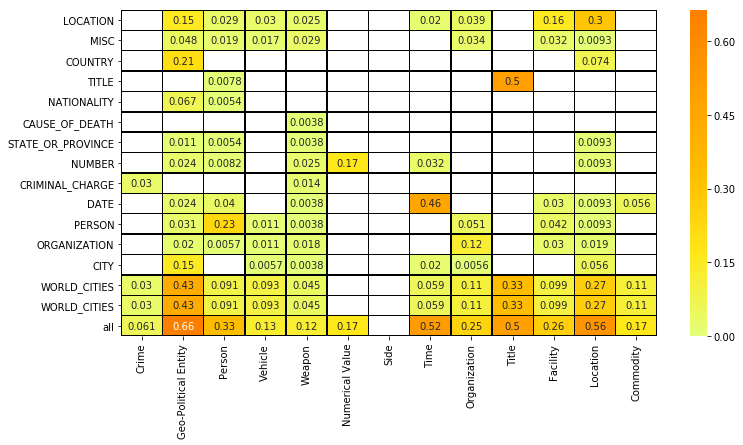

In [313]:
mask = np.zeros(all_recall.shape)
for i in range(len(all_recall)):
    for j in range(len(all_recall[0])):
        if all_recall[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(all_recall,xticklabels=darpa_full_categories,yticklabels=corenlp_keep+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [223]:
all_recall = []
all_precision = []
for corenlp_category in corenlp_categories:
    recall = []
    precision = []
    for darpa_category in darpa_event_categories:
        #Average recall - how many of the relevant items are selected?
        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_lower,t101_events_darpa_lower)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_lower,t102_events_darpa_lower)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_lower,t103_events_darpa_lower)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        recall.append(avg_recall)
        precision.append(avg_precision)
    all_recall.append(recall)
    all_precision.append(precision)

In [224]:
mask = []
for i in range(len(all_recall)):
    _mask = []
    for j in range(len(all_recall[0])):
        if all_recall[i][j] == 0:
            _mask.append(True)
        else:
            _mask.append(False)
    mask.append(_mask)
plt.rcParams["figure.figsize"] = (12,8)
sns.heatmap(all_recall,xticklabels=darpa_event_categories,yticklabels=corenlp_categories,mask=np.matrix(mask),\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [225]:
mask = []
for i in range(len(all_precision)):
    _mask = []
    for j in range(len(all_precision[0])):
        if all_precision[i][j] == 0:
            _mask.append(True)
        else:
            _mask.append(False)
    mask.append(_mask)
plt.rcParams["figure.figsize"] = (12,8)
sns.heatmap(all_precision,xticklabels=darpa_event_categories,yticklabels=corenlp_categories,mask=np.matrix(mask),\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

In [226]:
#Overall precision and recall
print(overall_recall_precision(t101_entities_corenlp_lower,t101_events_darpa_lower))
print(overall_recall_precision(t102_entities_corenlp_lower,t102_events_darpa_lower))
print(overall_recall_precision(t103_entities_corenlp_lower,t103_events_darpa_lower))

(0.0625, 0.005402485143165856)
(0.038461538461538464, 0.006644518272425249)
(0.1016949152542373, 0.0073439412484700125)


In [227]:
#What if we remove unnecessary corenlp categories?
corenlp_keep_events = ['LOCATION','CAUSE_OF_DEATH','CRIMINAL_CHARGE','DATE','ORGANIZATION']

In [229]:
print(overall_recall_precision([i for i in t101_entities_corenlp_lower if i[1] in corenlp_keep],t101_events_darpa_lower))
print(overall_recall_precision([i for i in t102_entities_corenlp_lower if i[1] in corenlp_keep],t102_events_darpa_lower))
print(overall_recall_precision([i for i in t103_entities_corenlp_lower if i[1] in corenlp_keep],t103_events_darpa_lower))

(0.0625, 0.005906674542232723)
(0.038461538461538464, 0.007425742574257425)
(0.1016949152542373, 0.00846262341325811)


In [242]:
all_recall = np.zeros((len(corenlp_keep_events)+1,len(darpa_event_categories)))
all_precision = np.zeros((len(corenlp_keep_events)+1,len(darpa_event_categories)))

for corenlp_category_index in range(len(corenlp_keep_events)):
    for darpa_category_index in range(len(darpa_event_categories)):
        corenlp_category = corenlp_keep_events[corenlp_category_index]
        darpa_category = darpa_event_categories[darpa_category_index]

        (t101_recall,t101_precision) = recall_precision(corenlp_category,darpa_category,t101_entities_corenlp_lower,t101_events_darpa_lower)
        (t102_recall,t102_precision) = recall_precision(corenlp_category,darpa_category,t102_entities_corenlp_lower,t102_events_darpa_lower)
        (t103_recall,t103_precision) = recall_precision(corenlp_category,darpa_category,t103_entities_corenlp_lower,t103_events_darpa_lower)
        avg_recall = (t101_recall+t102_recall+t103_recall)/3
        avg_precision = (t101_precision+t102_precision+t103_precision)/3
        
        all_recall[corenlp_category_index,darpa_category_index] = avg_recall
        all_precision[corenlp_category_index,darpa_category_index] = avg_precision
        
for darpa_category_index in range(len(darpa_event_categories)):
    darpa_category = darpa_event_categories[darpa_category_index]
    
    (t101_recall,t101_precision) = recall_precision_overall_corenlp(darpa_category,t101_entities_corenlp_lower,t101_events_darpa_lower)
    (t102_recall,t102_precision) = recall_precision_overall_corenlp(darpa_category,t102_entities_corenlp_lower,t102_events_darpa_lower)
    (t103_recall,t103_precision) = recall_precision_overall_corenlp(darpa_category,t103_entities_corenlp_lower,t103_events_darpa_lower)    
    avg_recall = (t101_recall+t102_recall+t103_recall)/3
    avg_precision = (t101_precision+t102_precision+t103_precision)/3
    
    all_recall[len(corenlp_keep_events),darpa_category_index] = avg_recall
    all_precision[len(corenlp_keep_events),darpa_category_index] = avg_precision

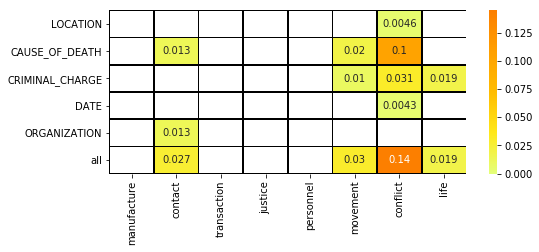

In [243]:
mask = np.zeros(all_recall.shape)
for i in range(len(all_recall)):
    for j in range(len(all_recall[0])):
        if all_recall[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (8,3)
sns.heatmap(all_recall,xticklabels=darpa_event_categories,yticklabels=corenlp_keep_events+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)

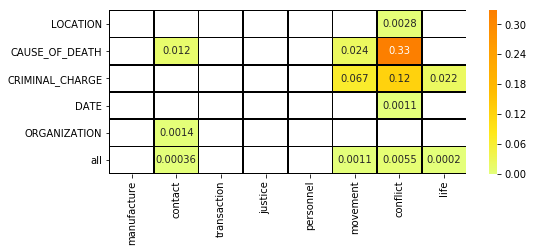

In [244]:
mask = np.zeros(all_precision.shape)
for i in range(len(all_precision)):
    for j in range(len(all_precision[0])):
        if all_recall[i,j] == 0:
            mask[i,j] = True
        else:
            mask[i,j] = False
plt.rcParams["figure.figsize"] = (8,3)
sns.heatmap(all_precision,xticklabels=darpa_event_categories,yticklabels=corenlp_keep_events+['all'],mask=mask,\
           linewidths=0.5,linecolor='black',cmap='Wistia',annot=True)